## Intro to fMRI Data Part II Correlation Maps

This is the Python Jupyter Notebook for the second Medium article about the organization and visualization of fMRI data.

First we start with importing the libraries for analysing and visualizing the dataset we downloaded and organized in the [previous notebook](https://github.com/akcarsten/akcarsten.github.io/blob/master/fMRI_data_analysis/Intro%20to%20fMRI%20Data.ipynb).

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Enable plots inside the Jupyter Notebook
%matplotlib inline

Next we load one of the .csv data files we created in the previous notebook.

In [3]:
# Import the data for slice 36
data = np.genfromtxt('tempcsv_data/slice_36.csv', delimiter=',')

Now we need more information from the README.txt file of the dataset to get the dimensions of the scan right and also to create our design matrix later in this project.

In [5]:
# These are the main parameters of the fMRI scan and experimental desgin
block_design    = ['rest', 'stim']
block_size      = 6
block_RT        = 7
block_total     = 16
block_length    = block_size*block_RT

acq_num         = block_size*block_total
data_time       = block_length*block_total
data_time_vol   = np.arange(acq_num)*block_RT

x_size = 64
y_size = 64

Lets first check the shape of the data matrix

In [7]:
print(data.shape)

(4096, 96)


Now we need to reshape the data. Remember we previously reshaped it so that we could save ist as a .csv file but now we need to transform it back to a 3D array. Since we have one slice of the scan loaded the dimensions should be 64x64 voxels with each voxel having 96 timepoints. So lets reshape the data.

In [8]:
data_ordered = data.reshape(x_size,y_size,acq_num)
print(data_ordered.shape)

(64, 64, 96)


Ok that looks better. Now if we want to have a look at the data we an either look at a specific volume or we can average all volumes (time points) for each voxel to see the mean signal intensity. In both cases we need to end up with a 64x64 matrix. 

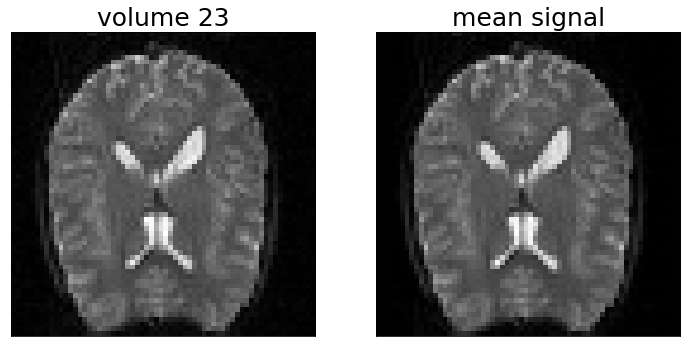

In [13]:
# Average all volumes
mean_data = data_ordered.mean(axis=2)

# Create plots
fig, ax = plt.subplots(1, 2,figsize=(12, 6))

# Plot volume number 23
ax[0].imshow(data_ordered[:, :, 23], cmap='gray')
ax[0].set_title('volume 23', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

# PLot mean signal intensities
ax[1].imshow(mean_data, cmap='gray')
ax[1].set_title('mean signal', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])
plt.show()

OK that looks like a brain section, very good. Now how does the time course of a (random) voxel from this scan look like?


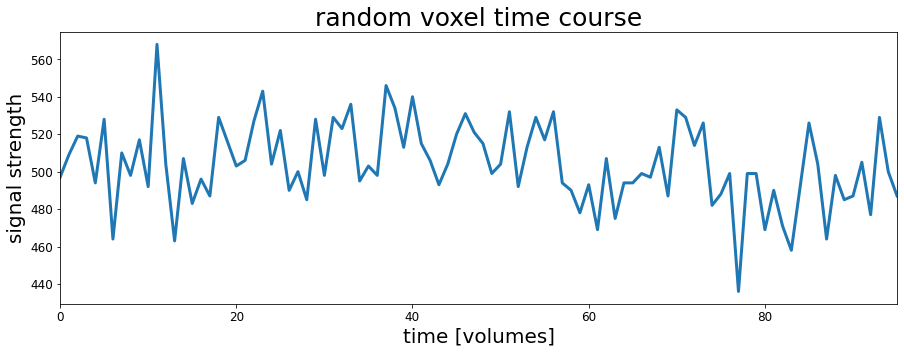

In [14]:
# Select a random voxel by getting one random x- and y-coorinate
x_voxel = np.random.randint(64)
y_voxel = np.random.randint(64)

# Create the plot
fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(data_ordered[x_voxel, y_voxel], lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.set_ylabel('signal strength', fontsize=20)
ax.set_title('random voxel time course', fontsize=25)
ax.tick_params(labelsize=12)
plt.show()

OK this doesn't look like much. So lets think: How would you imagine the response to look like? <br>
For now, lets keep things simple and just assume that without a stimulus (the playing of the "bi-syllabic words") the signal is at a baseline level and during the stimulation the signal goes up. <br>
In the following we will create a "design matrix" which represents this hypothesis. The design matrix also contains a constant part which we will need later on to create our general linear model.

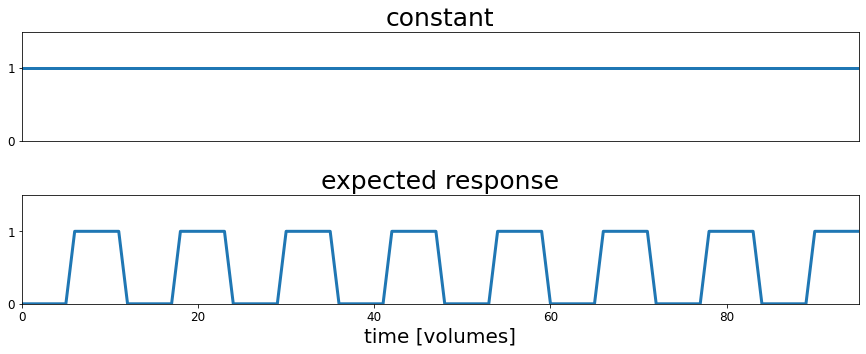

In [15]:
# Create the design matrix
constant = np.ones(acq_num)
rest     = np.zeros(block_size)
stim     = np.ones(block_size)
block    = np.concatenate((rest, stim), axis=0)
predicted_response = np.tile(block, int(block_total/2))

design_matrix = np.array((constant, predicted_response))

# Create the plots
fig, ax = plt.subplots(2,1, figsize=(15, 5))
ax[0].plot(design_matrix[0], lw=3)
ax[0].set_xlim(0, acq_num-1)
ax[0].set_ylim(0, 1.5)
ax[0].set_title('constant', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([0,1])
ax[0].tick_params(labelsize=12)
ax[0].tick_params(labelsize=12)

ax[1].plot(design_matrix[1], lw=3)
ax[1].set_xlim(0, acq_num-1)
ax[1].set_ylim(0, 1.5)
ax[1].set_title('expected response', fontsize=25)
ax[1].set_yticks([0,1])
ax[1].set_xlabel('time [volumes]', fontsize=20)
ax[1].tick_params(labelsize=12)
ax[1].tick_params(labelsize=12)

fig.subplots_adjust(wspace=0, hspace=0.5)
plt.show()

Well is this a good approximation to the response of the brain? If so we should see some voxel that has a similar timecourse right?
In order to find the voxel that comes closest to our model we can try a simple correlation analysis.


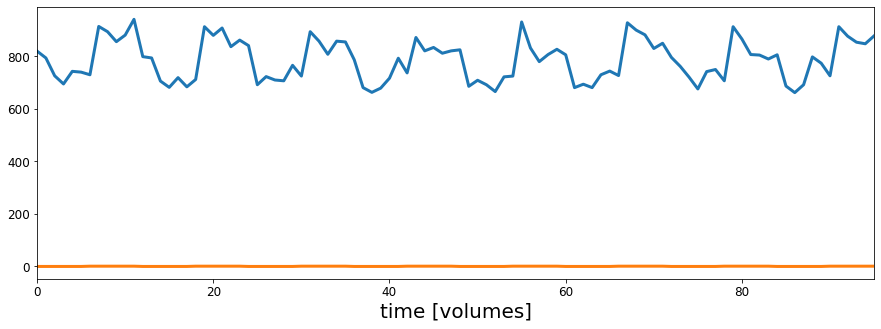

In [16]:
# Calculate the correlation coefficients
c = np.corrcoef(design_matrix[1,:], data)[1:,0]

# Find the voxel with the highest correlation coefficient
strongest_correlated = data[c.argmax(),:]

# Create the plots
fig, ax = plt.subplots(1,1,figsize=(15, 5))
ax.plot(strongest_correlated, lw=3)
ax.plot(design_matrix[1,:], lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.tick_params(labelsize=12)
plt.show()

Yes the timecourse looks similar to our assumption but the data has a big offset. Lets normalise so we can visualize it better<br>
One simple way of normalizing the data is min-max-scaling.<br>
$$x scaled = [x - min(x)]/[max(x)-min(x)]$$

In [17]:
# Define the min-max scaling function
def scale(data):
    return (data - data.min()) / (data.max() - data.min())

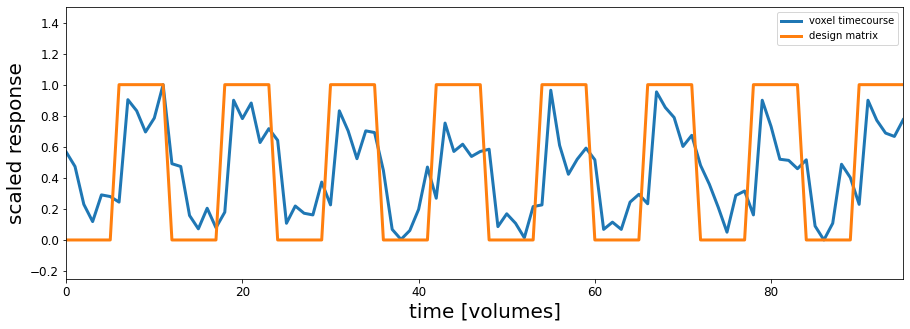

In [19]:
# Scale the voxel with the highest correlation
strongest_correlated_scaled = scale(data[c.argmax(),:])

# Create the plots
fig, (ax) = plt.subplots(1,1,figsize=(15, 5))
ax.plot(strongest_correlated_scaled, label='voxel timecourse', lw=3)
ax.plot(design_matrix[1,:], label='design matrix', lw=3)
ax.set_xlim(0, acq_num-1)
ax.set_ylim(-0.25, 1.5)
ax.set_xlabel('time [volumes]', fontsize=20)
ax.set_ylabel('scaled response', fontsize=20)
ax.tick_params(labelsize=12)
ax.legend()
plt.show()

OK now we can see that the timecourse looks similar to our assumption. But how are voxels that correlate with our idealized timecourse distributed across the brain? Lets check.<br>
First we reshape the correlation vector to a 64x64 matrix. This should match the mean signal map we created before.
Second we can slect a threshold so that we only see voxels that have a correlation coefficiant higher than... lets say 0.2.

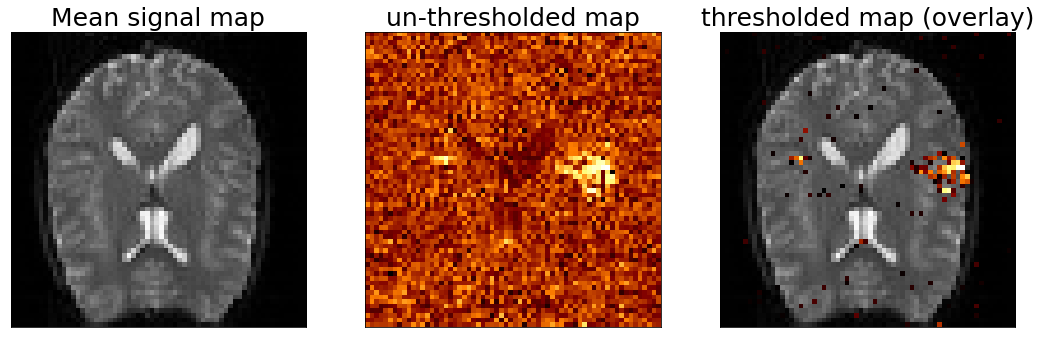

In [20]:
corr = c.reshape(x_size, y_size)
map = corr.copy()
map[map < 0.2] = np.nan

# Ok now lets visualize all the maps
fig, ax = plt.subplots(1,3,figsize=(18, 6))

# Create the plots
ax[0].imshow(mean_data, cmap='gray')
ax[0].set_title('Mean signal map', fontsize=25)
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[1].imshow(corr,  cmap='afmhot')
ax[1].set_title('un-thresholded map', fontsize=25)
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[2].imshow(mean_data, cmap='gray')
ax[2].imshow(map, cmap='afmhot')
ax[2].set_title('thresholded map (overlay)', fontsize=25)
ax[2].set_yticks([])
ax[2].set_xticks([])
ax[2].set_yticks([])

plt.show()

OK as we can see from the un-thresholded map the voxels with high correlations are not randomly distributed across the map but actually form a bigger cluster on the right side and a smaller cluster on the left side of the map. Finally we can see from the overlay that both clusters are located within the brain. The region were they are located is actually the auditory cortex which - as you may have guessed - is involved in processing auditory information.